In [5]:

from google.colab import drive
drive.mount('/content/drive')

!unzip -q "/content/drive/MyDrive/GERALD_subset.zip" -d "/content/"

print("Done! Dataset extracted to /content/GERALD_subset")


Mounted at /content/drive
Done! Dataset extracted to /content/GERALD_subset


In [2]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.4 MB/s eta 0:00:00


In [3]:
import cv2
import numpy as np
from pathlib import Path
import xml.etree.ElementTree as ET
from ultralytics import YOLO
import tensorflow as tf
from tensorflow.keras.models import load_model


class WeatherAwareSignalDetector:
    """
    The model combines:
    - YOLO
    - MobileNetV2

    The pipeline integrates a weather-adaptive confidence threshold (WACT)
    and a simple fusion strategy where high-confidence YOLO predictions
    override classifier outputs.
    """

    def __init__(self, yolo_model_path: str, classifier_model_path: str):
        """Initialize YOLO and classifier models with weather thresholds."""

        # Load models
        self.yolo_model = YOLO(yolo_model_path)
        self.classifier = load_model(classifier_model_path)

        # Weather Adaptive Confidence Thresholds (WACT)
        self.wact_thresholds = {
            "Sunny": 0.20,
            "Rainy": 0.30,
            "Cloudy": 0.25,
            "Foggy": 0.35,
            "Snowy": 0.20,
            "Unknown": 0.20
        }

        # Image size expected by MobileNetV2
        self.img_size = (224, 224)

        # Class mapping
        self.yolo_class_names = ["main_signal", "distant_signal"]
        self.classifier_class_names = ["distant_signal", "main_signal"]

    # METADATA
    def get_weather_from_metadata(self, xml_path: str) -> str:
        """Extract weather condition from XML metadata file."""
        try:
            root = ET.parse(xml_path).getroot()
            metadata = root.find("metadata")
            if metadata is not None:
                weather = metadata.find("weather")
                if weather is not None:
                    return weather.text
        except Exception:
            pass

        return "Unknown"

    # YOLO STAGE

    def detect_with_wact(self, image_path: str, weather: str):
        """
        Run YOLO detection using a weather-adaptive confidence threshold.
        """

        conf_threshold = self.wact_thresholds.get(weather, 0.25)
        results = self.yolo_model.predict(
            source=str(image_path),
            conf=conf_threshold,
            verbose=False
        )[0]

        detections = []
        if len(results.boxes) == 0:
            return detections

        for box, score, cls_id in zip(
            results.boxes.xyxy.cpu().numpy(),
            results.boxes.conf.cpu().numpy(),
            results.boxes.cls.cpu().numpy()
        ):
            detections.append({
                "bbox": box.tolist(),
                "yolo_confidence": float(score),
                "yolo_class_id": int(cls_id),
                "yolo_class": self.yolo_class_names[int(cls_id)]
            })

        return detections

    # CLASSIFIER STAGE
    def classify_detection(self, image, bbox):
        """
        Classify the cropped region from YOLO using MobileNetV2.
        Applies 25% padding to include more context.
        """

        x1, y1, x2, y2 = map(int, bbox)
        h, w = image.shape[:2]

        # Padding
        pad_x = int((x2 - x1) * 0.25)
        pad_y = int((y2 - y1) * 0.25)

        x1 = max(0, x1 - pad_x)
        y1 = max(0, y1 - pad_y)
        x2 = min(w, x2 + pad_x)
        y2 = min(h, y2 + pad_y)

        # Invalid box check
        if x2 <= x1 or y2 <= y1:
            return None, 0.0

        crop = image[y1:y2, x1:x2]
        crop = cv2.resize(crop, self.img_size)
        crop = crop.astype("float32") / 255.0
        crop = np.expand_dims(crop, axis=0)

        predictions = self.classifier.predict(crop, verbose=False)[0]
        class_id = int(np.argmax(predictions))
        confidence = float(predictions[class_id])

        return self.classifier_class_names[class_id], confidence

    # HYBRID PIPELINE
    def predict(self, image_path: str, xml_path: str = None):
        """
        Full hybrid pipeline:
        1. Weather extraction
        2. YOLO detection
        3. MobileNet classification
        4. Final fusion decision
        """

        # Load image
        image = cv2.imread(str(image_path))
        if image is None:
            print(f"[ERROR] Cannot read image: {image_path}")
            return []

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Weather metadata
        weather = "Unknown"
        if xml_path and Path(xml_path).exists():
            weather = self.get_weather_from_metadata(xml_path)

        # YOLO detection
        yolo_detections = self.detect_with_wact(image_path, weather)

        results = []

        print("\n---------AGREEMENT REPORT -----------")

        for det in yolo_detections:
            refined_class, clf_conf = self.classify_detection(
                image_rgb, det["bbox"]
            )

            if refined_class is None:
                continue

            # Fusion rule: YOLO overrides if very confident
            if det["yolo_confidence"] > 0.75:
                final_class = det["yolo_class"]
            else:
                final_class = refined_class

            agreement = (det["yolo_class"] == refined_class)

            # Log summary
            print(
                f"\nBBOX: {det['bbox']}\n"
                f"  YOLO: {det['yolo_class']} ({det['yolo_confidence']:.2f})\n"
                f"  CLF : {refined_class} ({clf_conf:.2f})\n"
                f"  FINAL: {final_class} → "
                f"{'AGREEMENT' if agreement else 'DISAGREEMENT'}"
            )

            results.append({
                "bbox": det["bbox"],
                "yolo_class": det["yolo_class"],
                "yolo_confidence": det["yolo_confidence"],
                "refined_class": refined_class,
                "classifier_confidence": clf_conf,
                "final_class": final_class,
                "weather": weather,
                "agreement": agreement
            })

        return results

    # VISUALIZATION

    def visualize_results(self, image_path: str, results, save_path: str = None):
        """Draw bounding boxes and final class predictions."""

        image = cv2.imread(str(image_path))
        if image is None:
            return None

        for r in results:
            x1, y1, x2, y2 = map(int, r["bbox"])

            # Coloring logic
            if r["agreement"]:
                color = (0, 255, 0)  # Green
            elif r["yolo_confidence"] > 0.75:
                color = (0, 255, 255)  # Yellow
            else:
                color = (0, 0, 255)  # Red

            cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)

            label = (
                f"{r['final_class']}\n"
                f"YOLO: {r['yolo_confidence']:.2f}\n"
                f"Clf: {r['classifier_confidence']:.2f}\n"
                f"{'AGREE' if r['agreement'] else 'DISAGREE'}"
            )

            # Draw multiline label
            for i, line in enumerate(label.split("\n")):
                cv2.putText(
                    image,
                    line,
                    (x1, y1 - 10 - i * 20),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.5,
                    color,
                    2
                )

        if save_path:
            cv2.imwrite(str(save_path), image)

        return image


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [6]:

if __name__ == "__main__":

    detector = WeatherAwareSignalDetector(
        yolo_model_path="/content/drive/MyDrive/signal_augmented/best.pt",
        classifier_model_path="/content/drive/MyDrive/MobileVnet/MobileNetV2.h5"
    )

    test_image_dir = Path("/content/drive/MyDrive/GERALD_test_set/images")
    save_dir = Path("hybrid_results")
    save_dir.mkdir(exist_ok=True)

    # Collect image list
    image_paths = []
    for ext in ["*.jpg", "*.png", "*.jpeg"]:
        image_paths.extend(list(test_image_dir.glob(ext)))

    print(f"\nFound {len(image_paths)} test images.\n")

    # Store ALL results for later statistical analysis
    all_results = []

    for image_path in image_paths:
        print("\n-------------------------------------------")
        print(f"PROCESSING IMAGE: {image_path.name}")
        print("---------------------------------------------")

        # Run hybrid detection
        result = detector.predict(
            image_path=str(image_path),
            xml_path=str(image_path).replace("images", "annotations").replace(".jpg", ".xml")
        )

        # Append results for publication tables
        all_results.append({
            "image": image_path.name,
            "detections": result
        })

        # Save visualization
        save_path = save_dir / f"{image_path.stem}_hybrid.jpg"
        detector.visualize_results(str(image_path), result, save_path=save_path)

        print(f"→ Saved annotated image to: {save_path}")

    print("\n------------------------------------------")
    print("     HYBRID DETECTION COMPLETE (ALL IMAGES)")
    print("---------------------------------------------")

    # Final summary report
    total_dets = sum(len(r["detections"]) for r in all_results)
    disagreements = sum(
        1 for r in all_results for d in r["detections"] if not d["agreement"]
    )
    agreements = total_dets - disagreements

    print(f"\nTotal detections: {total_dets}")
    print(f"Agreement:        {agreements}")
    print(f"Disagreement:     {disagreements}")



Found 79 test images.


-------------------------------------------
PROCESSING IMAGE: Werlau-K%C3%B6ln.mp4#t=528.333333.jpg
---------------------------------------------

---------AGREEMENT REPORT -----------

BBOX: [760.7772827148438, 444.08184814453125, 785.4335327148438, 472.90777587890625]
  YOLO: distant_signal (0.61)
  CLF : distant_signal (0.64)
  FINAL: distant_signal → AGREEMENT
→ Saved annotated image to: hybrid_results/Werlau-K%C3%B6ln.mp4#t=528.333333_hybrid.jpg

-------------------------------------------
PROCESSING IMAGE: Koeln-Opladen#t=620.068966.jpg
---------------------------------------------

---------AGREEMENT REPORT -----------

BBOX: [905.0909423828125, 387.6030578613281, 929.1156616210938, 414.7239074707031]
  YOLO: distant_signal (0.29)
  CLF : distant_signal (0.74)
  FINAL: distant_signal → AGREEMENT

BBOX: [908.4494018554688, 374.1797790527344, 929.4395141601562, 402.4106140136719]
  YOLO: distant_signal (0.26)
  CLF : distant_signal (0.94)
  FINAL: distant_

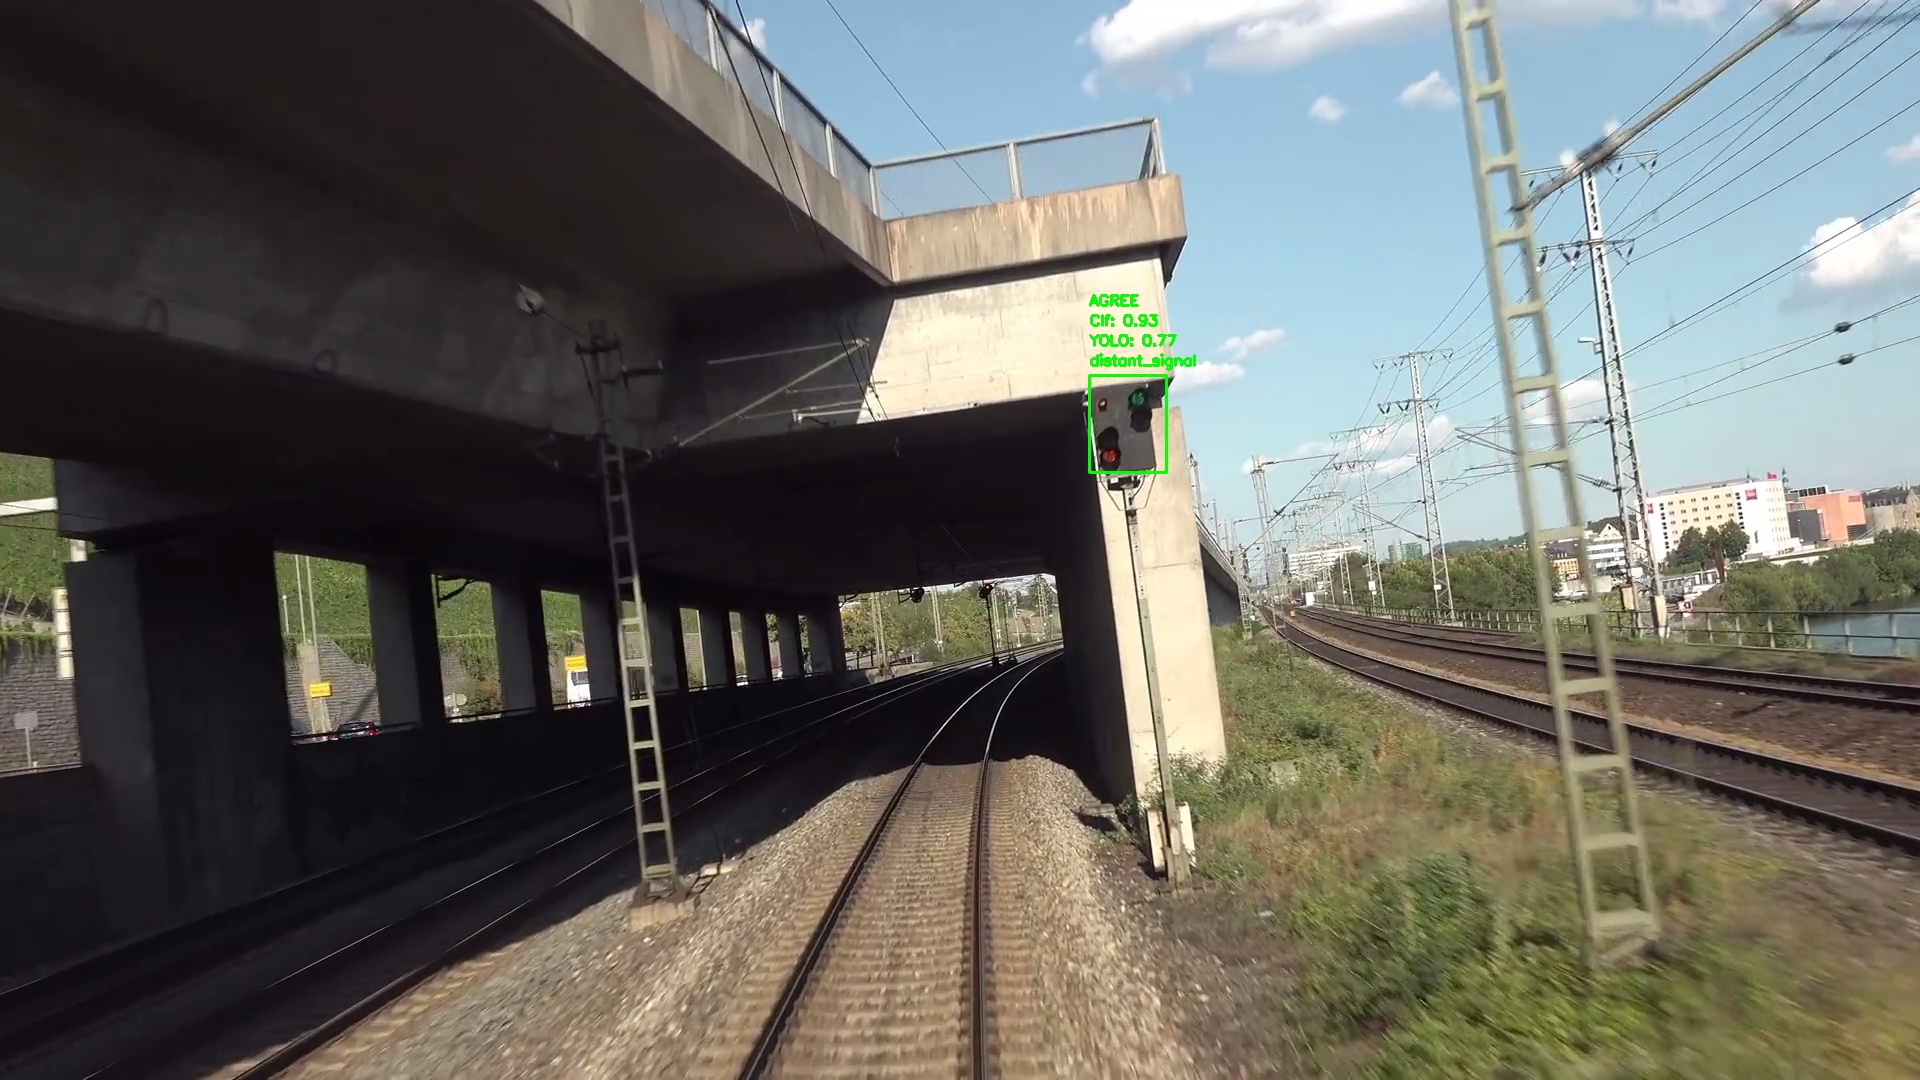

In [7]:
from IPython.display import Image
Image("hybrid_results/Wuerzburg-Nuernberg.mp4#t=123.733333_hybrid.jpg")
